In [1]:
from defillama2 import DefiLlama
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar: logical
        If True, will add $ in front of the numbers.
    decimals: int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

## Create a DefiLlama instance

In [3]:
obj = DefiLlama()

## Get latest yields for all pools, along with other info

In [4]:
df = obj.get_pools_yields() # See https://defillama.com/yields for the meaning of columns.
print(df.shape)
df.head() 

(9616, 24)


,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,...,sigma,count,outlier,underlyingTokens,predictedClass,predictedProbability,binnedConfidence
0,Ethereum,lido,stETH,5943830404,5.0000,NaN,5.0000,...,0.0227,157,False,None,Stable/Up,68.0000,2.0000
1,Tron,justlend,BTC,2272944503,0.0000,0.0321,0.0321,...,0.0010,92,False,[TN3W4H6rK2ce4vX9YnFQHwKENnHjoxb3m9],Stable/Up,60.0000,1.0000
2,Ethereum,curve,ETH-stETH,1693816062,2.9705,2.8466,5.8171,...,1.5905,238,True,"[0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE, 0...",Stable/Up,64.0000,2.0000
3,Ethereum,aave-v2,STETH,1153362913,0.0000,NaN,0.0000,...,0.0000,71,False,[0xae7ab96520de3a18e5e111b5eaab095312d7fe84],None,NaN,NaN
4,Ethereum,convex-finance,ETH-stETH,964642776,2.9705,3.0781,6.0487,...,0.0884,238,False,"[0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE, 0...",Stable/Up,70.0000,2.0000


In [5]:
df.columns

Index(['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy',
       'rewardTokens', 'pool', 'apyPct1D', 'apyPct7D', 'apyPct30D',
       'stablecoin', 'ilRisk', 'exposure', 'poolMeta', 'mu', 'sigma', 'count',
       'outlier', 'underlyingTokens', 'predictedClass', 'predictedProbability',
       'binnedConfidence'],
      dtype='object')

In [6]:
# let's look at TriCrypto pools on Ethereum and Arbitrum, discarding outlier pools (with extreme APYs and usually low TVL)
is_true = (df.symbol.isin(['yvCurve-Tricrypto', 'USDT-WBTC-WETH', 'WBTC-WETH-USDC']) & 
           df.chain.isin(['Ethereum', 'Arbitrum']) & 
           (~df.outlier))

# I guess columns `mu` and `sigma` are mean and standard deviation of past APYs over `count` many APYs.
# `apyPct7D` is pct change in APY for the last 7 days; `apyPct30D` is NaN for all records.
# `predictedClass` is DeFiLlama's prediction on which way the APY is heading to. 
cols = ['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
4935,Arbitrum,yearn-finance,yvCurve-Tricrypto,134134,NaN,NaN,14.6385,0.0000,8.9406,0.2214,212,Down,64.0000
41,Ethereum,convex-finance,USDT-WBTC-WETH,182204483,0.9643,11.4365,12.4008,-1.4690,14.4187,0.4418,181,Stable/Up,69.0000
4795,Arbitrum,pickle,USDT-WBTC-WETH,142829,NaN,NaN,9.5418,-0.3470,10.2212,0.1754,150,Down,53.0000
677,Arbitrum,balancer,WBTC-WETH-USDC,5545981,2.3123,5.4292,7.7415,-2.9007,16.0033,0.3038,237,Stable/Up,74.0000
37,Ethereum,curve,USDT-WBTC-WETH,192248273,0.9643,5.7716,6.7359,-1.1422,8.7116,0.1991,238,Stable/Up,85.0000
314,Arbitrum,curve,USDT-WBTC-WETH,16685399,1.2875,0.0000,1.2875,-0.6319,1.3556,0.0496,194,Down,59.0000
6541,Ethereum,convex-finance,USDT-WBTC-WETH,55516,0.6000,0.0000,0.6000,"-999,999.4000",1.2959,0.0832,70,Down,56.0000
3010,Ethereum,curve,USDT-WBTC-WETH,383334,0.2124,0.0000,0.2124,-1.2963,0.7482,0.0472,194,Stable/Up,87.0000


In [7]:
# let's find multi-sided stablecoin pools without IL and with TVL > $1M on Arbitrum
is_true = (df.chain == 'Arbitrum') & df.stablecoin & (df.ilRisk == 'no') & (df.exposure == 'multi') & (df.tvlUsd > 1e6) & (~df.outlier)
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
1124,Arbitrum,uniswap,USDT-USDC,2511361,3.5337,NaN,3.5337,-0.2588,0.6158,0.0980,192,Down,70.0000
833,Arbitrum,uniswap,DAI-USDC,4091850,2.0526,NaN,2.0526,-12.4059,0.7588,0.1363,192,Down,65.0000
1316,Arbitrum,curve,FRAX-USDC,1963768,0.6931,0.0000,0.6931,-0.2979,1.2336,0.0690,69,Stable/Up,66.0000
532,Arbitrum,curve,VST-FRAX,8243565,0.3418,0.0000,0.3418,0.2363,0.2430,0.0137,79,Stable/Up,51.0000
947,Arbitrum,uniswap,USDs-USDC,3295651,0.1085,NaN,0.1085,-0.2809,0.0727,0.0149,192,Stable/Up,55.0000
220,Arbitrum,curve,USDC-USDT,26142653,0.0853,0.0000,0.0853,-0.0317,0.1515,0.0112,194,Stable/Up,53.0000
1339,Arbitrum,uniswap,TUSD-USDC,1904297,0.0000,NaN,0.0000,0.0000,0.0001,0.0000,77,None,NaN
1378,Arbitrum,uniswap,USDD-USDC,1804078,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,77,None,NaN


## Get historical APY and TVL of a pool

In [8]:
# get pool ids
dat = obj.get_pools_yields()
pool_ids = dat.pool
pool_ids

0       747c1d2a-c668-4682-b9f9-296708a3dd90
1       71418c17-d2aa-4eff-b68a-806fff9ec951
2       57d30b9c-fc66-4ac2-b666-69ad5f410cce
3       0e458a5b-fd99-4667-8706-dd938934cb0c
4       5ce23e7e-3800-4c9c-ad30-6db3db0515a1
                        ...                 
9611    904540ea-e24a-47b0-a169-7ef7bf6fe1da
9612    d1c14500-4873-432e-a1e3-58fbdff94516
9613    73b0e9e9-c358-48b1-a382-0ec051b27695
9614    8e91c2b5-1a00-4579-ac06-7036fe83cefa
9615    a5e17d52-509f-4e9f-890e-169317eb578f
Name: pool, Length: 9616, dtype: object

In [9]:
pool_id = pool_ids[10]
meta = dat.loc[dat.pool == pool_id, ['chain', 'project', 'symbol']]
meta

,chain,project,symbol
10,Ethereum,convex-finance,FRAX-USDC


In [10]:
df = obj.get_pool_hist_apy(pool_id)
df.head()

,tvlUsd,apy,apyBase,apyReward
date,,,,
2022-07-29,"468,964,646.0000",7.8991,0.1245,7.7746
2022-07-30,"501,848,968.0000",7.3514,0.0660,7.2853
2022-07-31,"505,533,915.0000",7.3834,0.0687,7.3146
2022-08-01,"516,768,403.0000",7.3928,0.0572,7.3356
2022-08-02,"518,273,918.0000",7.8588,0.1158,7.7431


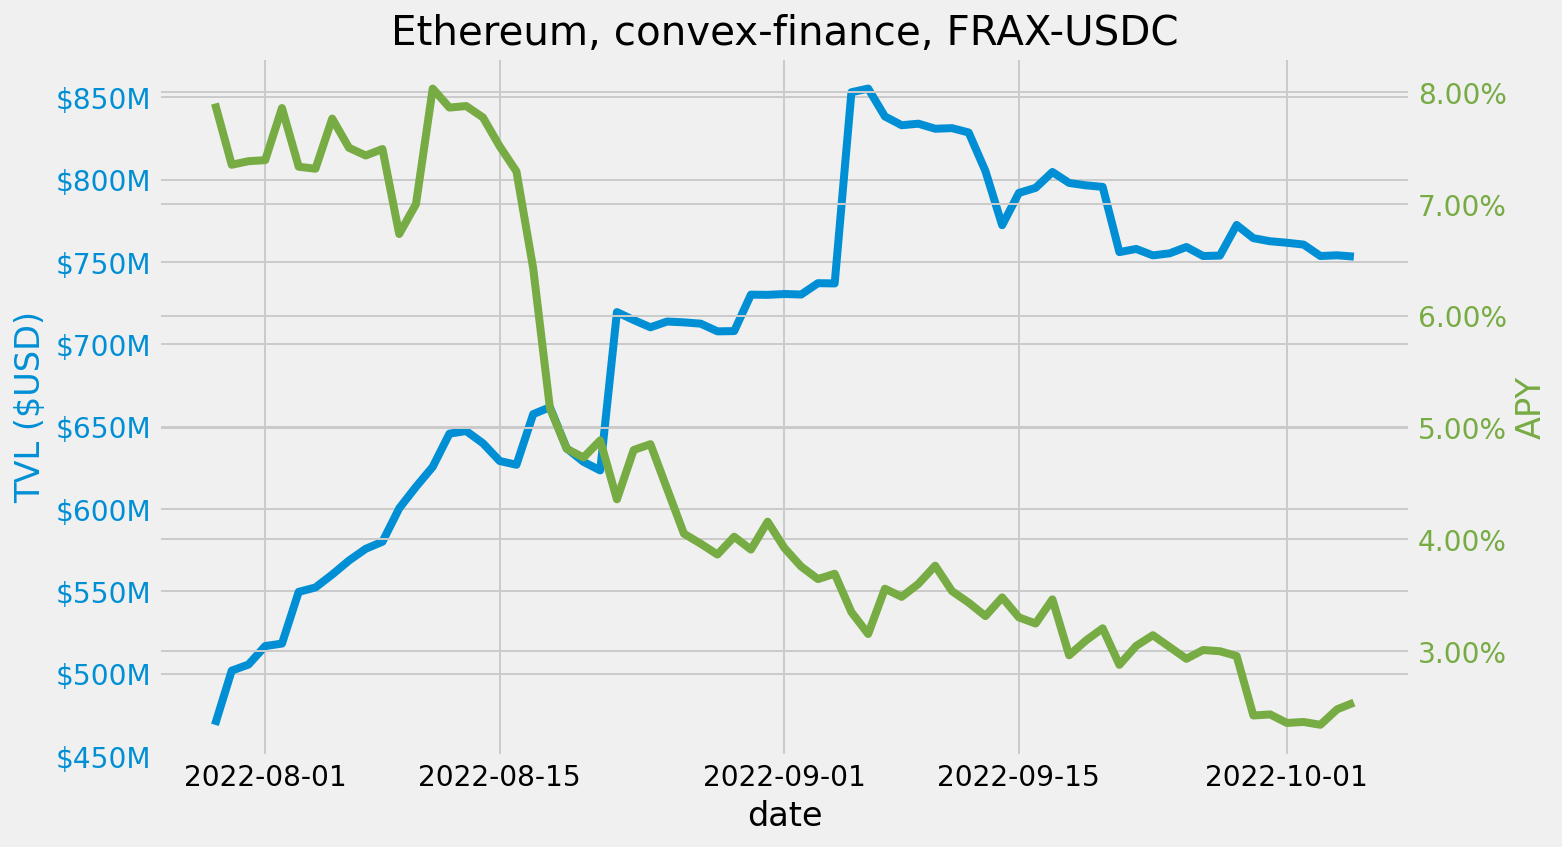

In [11]:
# plot both TVL and APY over time to see their relationships. 
ax1 = df.tvlUsd.plot()
dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax1.yaxis.set_major_formatter(dollar_formatter)
for tl in ax1.get_yticklabels():
    tl.set_color('#008FD5')
ax1.set_ylabel('TVL ($USD)', color='#008FD5')

ax2 = ax1.twinx()
ax2.plot(df.index, df.apy, color='#77AB43')
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
for tl in ax2.get_yticklabels():
    tl.set_color('#77AB43')
ax2.set_ylabel('APY', color='#77AB43')

fig_tit = ', '.join(meta.values.tolist()[0])
plt.title(fig_tit);    